<a href="https://colab.research.google.com/github/gabrielbruschi/predicao_acoes/blob/main/rede_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import StandardScaler #normalizar os dados
import matplotlib.pyplot as plt #grafico
from sklearn.model_selection import train_test_split #treinamento e teste

In [ ]:
plt.style.use('ggplot')

LSTM = long short term memory
fazemos a previsao pra quantos dias pra frente

In [ ]:
df = pd.read_csv('PTR4_bovespa_tratado.csv')
df

,preco_abertura,preco_maximo,preco_minimo,preco_fechamento,qtd_negocios,volume_negocio,data_pregao
0,6.39,6.39,6.39,6.39,3.186628,0.0,2002-01-01
1,6.45,6.49,6.39,6.41,3.192857,23920000.0,2002-01-02
2,6.49,6.50,6.42,6.45,3.214662,39043200.0,2002-01-03
3,6.38,6.45,6.32,6.41,3.194726,21500800.0,2002-01-04
4,6.38,6.60,6.38,6.55,3.264501,40406400.0,2002-01-07
...,...,...,...,...,...,...,...
5093,32.69,33.12,31.90,33.06,33.060001,129570200.0,2022-05-06
5094,32.70,33.04,32.06,32.16,32.160000,92314500.0,2022-05-09
5095,32.36,32.85,32.20,32.44,32.439999,60330600.0,2022-05-10
5096,32.78,33.91,32.69,33.57,33.570000,108895400.0,2022-05-11


In [ ]:
df = df.dropna()

In [ ]:
#formatar a data
#df['data_pregao'] = pd.to_datetime(df['data_pregao'], format = '%Y-%m-%d') #talvez alterar no ETL, ai n preciso ajustar aqui
#df['data_pregao,sigla_acao,nome_acao,preco_abertura,preco_maximo,preco_minimo,preco_fechamento,qtd_negocios,volume_negocio,data_pregrao']

In [ ]:
# Filtrar acao
#df_acao = df[df['sigla_acao'] == 'PETR4']

In [ ]:
#Selecionar os campos, pode ser utilizado diversas features

df_acao_fec = df[['data_pregao', 'preco_fechamento']]

In [ ]:
#Ajustar o index, a data 'e o index
df_acao_fec = df_acao_fec.set_index(pd.DatetimeIndex(df_acao_fec['data_pregao'].values))

In [ ]:
#Retirar coluna do data pregao
df_acao_fec.drop('data_pregao', axis=1, inplace=True)

In [ ]:
df_acao_fec

,preco_fechamento
2002-01-01,6.39
2002-01-02,6.41
2002-01-03,6.45
2002-01-04,6.41
2002-01-07,6.55
...,...
2022-05-06,33.06
2022-05-09,32.16
2022-05-10,32.44
2022-05-11,33.57


Text(0.5, 0, 'data')

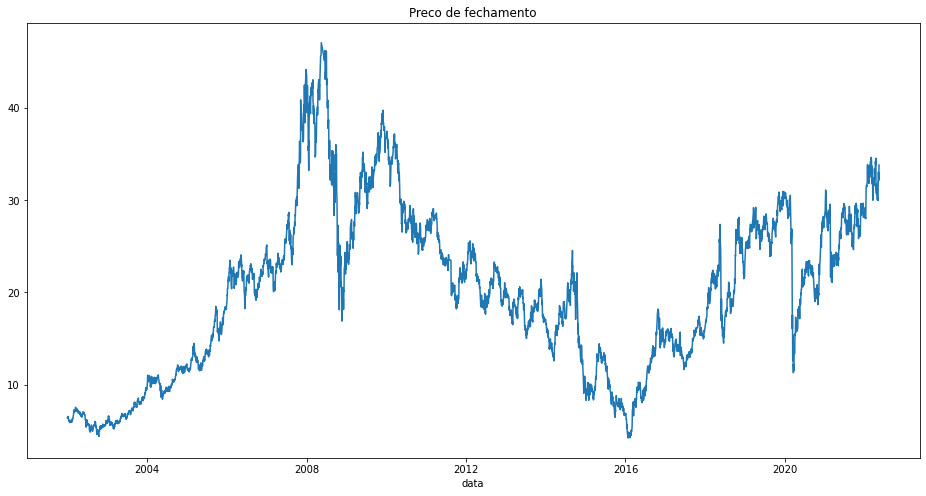

In [ ]:
#plotar informacao
plt.figure(figsize=(16,8))
plt.title('Preco de fechamento')
plt.plot(df_acao_fec['preco_fechamento'])
plt.xlabel('data')

In [ ]:
#verificar a quantidade de linhas
qtd_linhas = len(df_acao_fec)

qtd_linhas_treino = round(.70 * qtd_linhas)
qtd_linhas_teste = qtd_linhas - qtd_linhas_treino

info = (
    f"linhas treino = 0{qtd_linhas_treino}"
    f"linhas teste = {qtd_linhas_treino}:{qtd_linhas_treino + qtd_linhas_teste}"
)

info

'linhas treino = 03554linhas teste = 3554:5077'

In [ ]:
#nao queremos q o algortmo entenda que um valor alto 'e melhor

#Normalizar os dados
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_acao_fec)

In [ ]:
#Separa em treino e teste
train = df_scaled[:qtd_linhas_treino]
test = df_scaled[qtd_linhas_treino: qtd_linhas_treino + qtd_linhas_teste] 

print( len(train), len(test))

#n foi utilizado o train test split para manter a ordem, a ordem 'e importante em series temporais. Valores posteriores 'e intrisicamente relacionado a valores anteriores, por isso a separacao manual

3554 1523


In [ ]:
#Convert an array of values into a df matrix
#Rede LSTM
def create_df(df, steps=1):
  dataX, dataY = [], []
  for i in range(len(df) - steps - 1):
    a = df[i:(i+steps), 0]
    dataX.append(a)
    dataY.append(df[i + steps, 0])
  return np.array(dataX), np.array(dataY)

In [ ]:
#Gerando dados de treino e teste
steps = 15 
X_train, Y_train = create_df(train, steps)
X_test, Y_test = create_df(test, steps)

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(3538, 15)
(3538,)
(1507, 15)
(1507,)


In [ ]:
# Gerando os dados que o modelo espera
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) #1 'e a qntd de features
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
#Montando a rede
model = Sequential()
model.add(LSTM(35, return_sequences=True, input_shape=(steps, 1))) #35 neuronios, o return_seq = true : pega a informacao q sai e reinsere, dados com memoria
model.add(LSTM(35, return_sequences=True))
model.add(LSTM(35))
model.add(Dropout(0.05)) #ANTES ERA 0.2 #nao causar um overfit (rede muito treinada), dou uma penalizada na feature
model.add(Dense(1)) #saida unica do preco que queremos prever

In [ ]:
model.compile(optimizer='adam', loss='mse') #adam mais usado, loss: minimun sequer error, ver o quanto minha rede esta performando
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 35)            5180      
                                                                 
 lstm_1 (LSTM)               (None, 15, 35)            9940      
                                                                 
 lstm_2 (LSTM)               (None, 35)                9940      
                                                                 
 dropout (Dropout)           (None, 35)                0         
                                                                 
 dense (Dense)               (None, 1)                 36        
                                                                 
Total params: 25,096
Trainable params: 25,096
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Treinamento do modelo
validation = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=200, batch_size=15, verbose=2)
# ele vai validando para ver como esta perfomando, batch_size 'e quantidade de dias pra tras, verbose pra ver como as informacoes estao sendo plotadas

Epoch 1/200
236/236 - 15s - loss: 0.0767 - val_loss: 0.0456 - 15s/epoch - 64ms/step
Epoch 2/200
236/236 - 3s - loss: 0.0248 - val_loss: 0.0270 - 3s/epoch - 11ms/step
Epoch 3/200
236/236 - 2s - loss: 0.0198 - val_loss: 0.0225 - 2s/epoch - 9ms/step
Epoch 4/200
236/236 - 2s - loss: 0.0183 - val_loss: 0.0178 - 2s/epoch - 8ms/step
Epoch 5/200
236/236 - 2s - loss: 0.0171 - val_loss: 0.0176 - 2s/epoch - 9ms/step
Epoch 6/200
236/236 - 2s - loss: 0.0149 - val_loss: 0.0156 - 2s/epoch - 8ms/step
Epoch 7/200
236/236 - 2s - loss: 0.0125 - val_loss: 0.0120 - 2s/epoch - 8ms/step
Epoch 8/200
236/236 - 2s - loss: 0.0124 - val_loss: 0.0125 - 2s/epoch - 9ms/step
Epoch 9/200
236/236 - 2s - loss: 0.0102 - val_loss: 0.0104 - 2s/epoch - 8ms/step
Epoch 10/200
236/236 - 2s - loss: 0.0096 - val_loss: 0.0089 - 2s/epoch - 8ms/step
Epoch 11/200
236/236 - 2s - loss: 0.0096 - val_loss: 0.0080 - 2s/epoch - 8ms/step
Epoch 12/200
236/236 - 2s - loss: 0.0091 - val_loss: 0.0083 - 2s/epoch - 8ms/step
Epoch 13/200
236/236 

Text(0.5, 1.0, 'Validação e Performace do algoritmo LSTM')

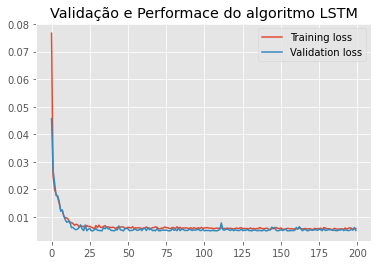

In [ ]:
#plt.figure(figsize=(16,8))
plt.plot(validation.history['loss'], label='Training loss')
plt.plot(validation.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Validação e Performace do algoritmo LSTM')

In [ ]:
#Fazendo previsao

prev = model.predict(X_test)
prev = scaler.inverse_transform(prev) #removo a normalizacao
prev # precos previstos

array([[ 9.48246 ],
       [ 9.752691],
       [ 9.319664],
       ...,
       [33.032143],
       [32.42496 ],
       [32.39816 ]], dtype=float32)

In [ ]:
#previsão para os proximos 10 dias

lenght_test = len(test)
lenght_test

1523

In [ ]:
#pegar os ultimos dias que são o tamanho do meu step - 15 dias

days_input_steps = lenght_test - steps
days_input_steps

1508

In [ ]:
#transforma em array

input_steps = test[days_input_steps:]
input_steps = np.array(input_steps).reshape(1,-1)
input_steps # informacao usada para prever os 10 dias a frente
#utilizamos os 15 dias para trás para prever os proximos 10 dias a frente

array([[1.20255691, 1.15205386, 1.14644241, 1.14644241, 1.16888821,
        1.17113279, 1.13746409, 1.16776592, 1.37202268, 1.36528894,
        1.48312937, 1.38212328, 1.4135474 , 1.54036615, 1.56954569]])

In [ ]:
#transformar em lista

list_output_steps = list(input_steps)
list_output_steps = list_output_steps[0].tolist()
list_output_steps

[1.202556906378153,
 1.1520538626689925,
 1.1464424133679745,
 1.1464424133679745,
 1.1688882105720462,
 1.1711327902924533,
 1.1374640944863463,
 1.1677659207118425,
 1.3720226752688915,
 1.3652889361076699,
 1.4831293714290448,
 1.3821232840107232,
 1.4135474000964232,
 1.5403661542994265,
 1.569545690664719]

In [ ]:
#loop para prever os proximos 10 dias

pred_output = []
i = 0
n_future = 10

while (i < n_future):
    
    if (len(list_output_steps) > steps):
        input_steps = np.array(list_output_steps[1:])
        print("{} dia. Valores de entrada -> {}".format(i,input_steps))
        input_steps = input_steps.reshape(1,-1)
        input_steps = input_steps.reshape((1, steps, 1))
        #print(input_steps)
        pred = model.predict(input_steps, verbose = 0)
        print("{} dia. Valor previsto -> {}".format(i, pred))
        list_output_steps.extend(pred[0].tolist())
        list_output_steps = list_output_steps[1:]
        #print(list_output_steps)
        pred_output.extend(pred.tolist())
        i = i + 1
    else:
        input_steps = input_steps.reshape((1, steps, 1))
        pred = model.predict(input_steps, verbose = 0)
        print(pred[0])
        list_output_steps.extend(pred[0].tolist())
        print(len(list_output_steps))
        pred_output.extend(pred.tolist())
        i = i + 1

print(pred_output)

[1.5710591]
16
1 dia. Valores de entrada -> [1.15205386 1.14644241 1.14644241 1.16888821 1.17113279 1.13746409
 1.16776592 1.37202268 1.36528894 1.48312937 1.38212328 1.4135474
 1.54036615 1.56954569 1.57105911]
1 dia. Valor previsto -> [[1.5640305]]
2 dia. Valores de entrada -> [1.14644241 1.14644241 1.16888821 1.17113279 1.13746409 1.16776592
 1.37202268 1.36528894 1.48312937 1.38212328 1.4135474  1.54036615
 1.56954569 1.57105911 1.56403053]
2 dia. Valor previsto -> [[1.5865592]]
3 dia. Valores de entrada -> [1.14644241 1.16888821 1.17113279 1.13746409 1.16776592 1.37202268
 1.36528894 1.48312937 1.38212328 1.4135474  1.54036615 1.56954569
 1.57105911 1.56403053 1.58655918]
3 dia. Valor previsto -> [[1.6061594]]
4 dia. Valores de entrada -> [1.16888821 1.17113279 1.13746409 1.16776592 1.37202268 1.36528894
 1.48312937 1.38212328 1.4135474  1.54036615 1.56954569 1.57105911
 1.56403053 1.58655918 1.60615945]
4 dia. Valor previsto -> [[1.6159724]]
5 dia. Valores de entrada -> [1.171132

In [ ]:
#transformar a saida

prev = scaler.inverse_transform(pred_output)
prev = np.array(prev).reshape(1, -1)
list_output_prev = list(prev)
list_output_prev = prev[0].tolist()
list_output_prev

[33.84348508232502,
 33.78085794863034,
 33.981596181909744,
 34.15624154647799,
 34.243678414937015,
 34.342243921111766,
 34.47393510217461,
 34.61194104425873,
 34.740871575381405,
 34.86992107256536]

In [ ]:
#pegar as datas de previsão 

dates = pd.to_datetime(df['data_pregao'])
predict_dates = pd.date_range(list(dates)[-1] + pd.DateOffset(1), periods = 10, freq='b').tolist() #freq b = dias bussins
predict_dates 

[Timestamp('2022-05-13 00:00:00', freq='B'),
 Timestamp('2022-05-16 00:00:00', freq='B'),
 Timestamp('2022-05-17 00:00:00', freq='B'),
 Timestamp('2022-05-18 00:00:00', freq='B'),
 Timestamp('2022-05-19 00:00:00', freq='B'),
 Timestamp('2022-05-20 00:00:00', freq='B'),
 Timestamp('2022-05-23 00:00:00', freq='B'),
 Timestamp('2022-05-24 00:00:00', freq='B'),
 Timestamp('2022-05-25 00:00:00', freq='B'),
 Timestamp('2022-05-26 00:00:00', freq='B')]

In [ ]:
#cria dataframe de previsao

forecast_dates = []
for i in predict_dates:
    forecast_dates.append(i.date())
    
df_forecast = pd.DataFrame({'data_pregao': np.array(forecast_dates), 'preco_fechamento': list_output_prev})
df_forecast['data_pregao'] = pd.to_datetime(df_forecast['data_pregao'])

df_forecast = df_forecast.set_index(pd.DatetimeIndex(df_forecast['data_pregao'].values))
df_forecast = df_forecast[df_forecast['data_pregao'] > '2022-04-01']
df_forecast.drop('data_pregao', axis = 1, inplace = True)
df_forecast

,preco_fechamento
2022-05-13,33.843485
2022-05-16,33.780858
2022-05-17,33.981596
2022-05-18,34.156242
2022-05-19,34.243678
2022-05-20,34.342244
2022-05-23,34.473935
2022-05-24,34.611941
2022-05-25,34.740872
2022-05-26,34.869921


In [ ]:
df_acao_fec = df[['data_pregao', 'preco_fechamento']]
df_acao_fec = df_acao_fec.set_index(pd.DatetimeIndex(df_acao_fec['data_pregao'].values))
df_acao_fec = df_acao_fec[df_acao_fec['data_pregao'] > '2022-01-01']
df_acao_fec.drop('data_pregao', axis=1, inplace=True)
df_acao_fec

,preco_fechamento
2022-01-03,29.09
2022-01-04,29.20
2022-01-05,28.07
2022-01-06,28.05
2022-01-07,28.18
...,...
2022-05-06,33.06
2022-05-09,32.16
2022-05-10,32.44
2022-05-11,33.57


Text(0.5, 1.0, 'Previsão de 10 dias da ação PETR4.SA')

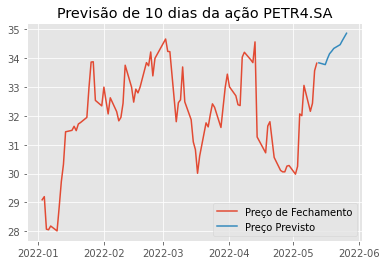

In [ ]:
#plotar o grafico

#plt.figure(figsize=(16,8))
plt.plot(df_acao_fec['preco_fechamento'], label='Preço de Fechamento')
plt.plot(df_forecast['preco_fechamento'], label='Preço Previsto')
plt.legend()
plt.title('Previsão de 10 dias da ação PETR4.SA')
